Remaining to-dos:

- Update dataset representations
    - Word-level semantic ID
- wav2vec2 distillation control

In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoConfig

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from transformers import Wav2Vec2Model
from models.transformer import Wav2Vec2ForSpeechClassification, DataCollator, \
    drop_wav2vec_layers
from utils.timit import TimitCorpus

In [10]:
import datasets
datasets.disable_caching()

In [11]:
model_name_or_path = "facebook/wav2vec2-base-960h"

processor = transformers.Wav2Vec2Processor.from_pretrained(model_name_or_path)

In [12]:
def get_phone_vocab(corpus):
    from models import Vocabulary
    phone_vocab = Vocabulary("phones")
    corpus.map(lambda x: [phone_vocab.add_token(phon) for phon in x["phonetic_detail"]["utterance"]] and None,
               batched=False, load_from_cache_file=False)
    return phone_vocab

def prepare_corpus():
    corpus = datasets.load_dataset("timit_asr", data_dir="../TIMIT/data/lisa/data/timit/raw/TIMIT")

    from utils.timit import group_phonetic_detail
    corpus = corpus.map(group_phonetic_detail, batched=False, load_from_cache_file=False)

    phone_vocab = get_phone_vocab(corpus)
    
    def prepare_audio(batch):
        audio = batch["audio"]
        batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
        return batch
    corpus = corpus.map(prepare_audio, num_proc=2)

    from models.transformer import TilingWordFeatureExtractor2
    twfe = TilingWordFeatureExtractor2(phone_vocab.index2token)
    def add_features(example):
        example["phone_targets"] = twfe(example)
        return example
    corpus = corpus.map(add_features, load_from_cache_file=False)
    
    return corpus, phone_vocab

In [13]:
corpus_path = "timit_corpus"

if not Path(corpus_path).exists():
    corpus, phone_vocab = prepare_corpus()
    corpus.save_to_disk(corpus_path)
else:
    corpus = datasets.load_from_disk(corpus_path)
    phone_vocab = get_phone_vocab(corpus)

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4620 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/4620 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1680 [00:00<?, ? examples/s]

In [14]:
# Load wav2vec2
config = AutoConfig.from_pretrained(
    model_name_or_path,
    problem_type="multi_label_classification",
    num_labels=len(phone_vocab))  # TODO magic number
setattr(config, "pooling_mode", "mean")

In [15]:
def model_init(trial):
    model = Wav2Vec2ForSpeechClassification.from_pretrained(
        model_name_or_path, config=config)

    model.freeze_feature_extractor()
    model.wav2vec2 = drop_wav2vec_layers(model.wav2vec2, 10)
    
    return model

## Train

In [16]:
from sklearn.metrics import roc_auc_score
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = preds.reshape((-1, preds.shape[-1]))
    labels = p.label_ids.reshape((-1, preds.shape[-1]))

    def evaluate_label(j):
        preds_j = preds[:, j]
        labels_j = labels[:, j]

        mask = labels_j != -100
        preds_j = preds_j[mask]
        labels_j = labels_j[mask]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

    # preds = np.argmax(preds, axis=-1)
    # return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [18]:
coll = DataCollator(processor=processor, model=model_init(None), padding=True,
                    num_labels=len(phone_vocab.index2token))

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="testrun5",
    group_by_length=True,
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=2,
    gradient_accumulation_steps=2,
    save_steps=50,
    eval_steps=25,
    logging_steps=2,
    learning_rate=1e-4,
    save_total_limit=5,
    use_cpu=True,
    use_mps_device=False,
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=None, model_init=model_init,
    data_collator=coll,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics,
    train_dataset=corpus["train"],
    eval_dataset=corpus["test"],
    tokenizer=processor.feature_extractor,
)

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from ray import tune
def hp_space(trial):
    return {
        "learning_rate": tune.loguniform(1e-5, 1e-3),
    }

In [29]:
reporter = tune.CLIReporter(
    parameter_columns={
        "learning_rate": "lr",
    },
    metric_columns=["eval_loss", "eval_roc_auc", "epoch", "training_iteration"],
)

best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="ray",
    resources_per_trial={"cpu": 1},
    hp_space=hp_space,
    n_trials=1,
    progress_reporter=reporter)

2023-11-10 13:01:46,677	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2023-11-10 13:01:46 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: /Users/jon/ray_results/_objective_2023-11-10_13-01-46
Number of trials: 1/1 (1 PENDING)




(_objective pid=64580) Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'wav2vec2.masked_spec_embed']
(_objective pid=64580) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


== Status ==
Current time: 2023-11-10 13:01:51 (running for 00:00:05.20)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: /Users/jon/ray_results/_objective_2023-11-10_13-01-46
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2023-11-10 13:01:56 (running for 00:00:10.30)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: /Users/jon/ray_results/_objective_2023-11-10_13-01-46
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2023-11-10 13:02:01 (running for 00:00:15.30)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: /Users/jon/ray_results/_objective_2023-11-10_13-01-46
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2023-11-10 13:02:07 (running for 00:00:20.40)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: /Users/jon/ray_results/_objective_2023-11-10_13-01-46
Number o

  0%|          | 0/288 [00:00<?, ?it/s]
2023-11-10 13:02:27,147	ERROR tune_controller.py:911 -- Trial task failed for trial _objective_5c043_00000
Traceback (most recent call last):
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/ray/_private/worker.py", line 2524, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=64580, ip=127.0.0.1, actor_id=1d29cd2ec6cc71f91a25046901000000, repr=_object

Trial name
_objective_5c043_00000


== Status ==
Current time: 2023-11-10 13:02:27 (running for 00:00:40.47)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/12 CPUs, 0/0 GPUs
Result logdir: /Users/jon/ray_results/_objective_2023-11-10_13-01-46
Number of trials: 1/1 (1 ERROR)
+------------------------+----------+-----------------+-------------+
| Trial name             | status   | loc             |          lr |
|------------------------+----------+-----------------+-------------|
| _objective_5c043_00000 | ERROR    | 127.0.0.1:64580 | 5.61152e-05 |
+------------------------+----------+-----------------+-------------+
Number of errored trials: 1
+------------------------+--------------+-----------------------------------------------------------------------------------------------------------------------------------+
| Trial name             |   # failures | error file                                                                                                                        |
|--------------------

TuneError: ('Trials did not complete', [_objective_5c043_00000])

(_objective pid=64580) /Users/jon/miniforge3/envs/explore310/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_objective pid=64580)   warnings.warn('resource_tracker: There appear to be %d '


In [236]:
# # Manual
# batch = next(iter(trainer.get_train_dataloader()))
# model(**batch)

In [237]:
# trainer.evaluate()

In [238]:
trainer.train()

  0%|          | 0/288 [00:00<?, ?it/s]

{'loss': 0.6902, 'learning_rate': 9.930555555555556e-05, 'epoch': 0.01}
{'loss': 0.6785, 'learning_rate': 9.861111111111112e-05, 'epoch': 0.03}
{'loss': 0.6618, 'learning_rate': 9.791666666666667e-05, 'epoch': 0.04}
{'loss': 0.6469, 'learning_rate': 9.722222222222223e-05, 'epoch': 0.06}
{'loss': 0.6188, 'learning_rate': 9.652777777777779e-05, 'epoch': 0.07}
{'loss': 0.5511, 'learning_rate': 9.583333333333334e-05, 'epoch': 0.08}
{'loss': 0.5109, 'learning_rate': 9.513888888888888e-05, 'epoch': 0.1}
{'loss': 0.4726, 'learning_rate': 9.444444444444444e-05, 'epoch': 0.11}
{'loss': 0.4345, 'learning_rate': 9.375e-05, 'epoch': 0.12}
{'loss': 0.3978, 'learning_rate': 9.305555555555556e-05, 'epoch': 0.14}
{'loss': 0.4198, 'learning_rate': 9.236111111111112e-05, 'epoch': 0.15}
{'loss': 0.3438, 'learning_rate': 9.166666666666667e-05, 'epoch': 0.17}


  0%|          | 0/210 [00:00<?, ?it/s]

{'eval_loss': 0.2798670530319214, 'eval_roc_auc': 0.509566330440309, 'eval_runtime': 126.9984, 'eval_samples_per_second': 13.229, 'eval_steps_per_second': 1.654, 'epoch': 0.17}
{'loss': 0.3906, 'learning_rate': 9.097222222222223e-05, 'epoch': 0.18}
{'loss': 0.328, 'learning_rate': 9.027777777777779e-05, 'epoch': 0.19}
{'loss': 0.2844, 'learning_rate': 8.958333333333335e-05, 'epoch': 0.21}
{'loss': 0.2696, 'learning_rate': 8.888888888888889e-05, 'epoch': 0.22}
{'loss': 0.2463, 'learning_rate': 8.819444444444445e-05, 'epoch': 0.24}
{'loss': 0.2652, 'learning_rate': 8.75e-05, 'epoch': 0.25}
{'loss': 0.2647, 'learning_rate': 8.680555555555556e-05, 'epoch': 0.26}
{'loss': 0.2571, 'learning_rate': 8.611111111111112e-05, 'epoch': 0.28}
{'loss': 0.2461, 'learning_rate': 8.541666666666666e-05, 'epoch': 0.29}
{'loss': 0.2378, 'learning_rate': 8.472222222222222e-05, 'epoch': 0.3}
{'loss': 0.2449, 'learning_rate': 8.402777777777778e-05, 'epoch': 0.32}
{'loss': 0.2332, 'learning_rate': 8.3333333333

  0%|          | 0/210 [00:00<?, ?it/s]

{'eval_loss': 0.1819174587726593, 'eval_roc_auc': 0.5483554842453656, 'eval_runtime': 129.0101, 'eval_samples_per_second': 13.022, 'eval_steps_per_second': 1.628, 'epoch': 0.35}
{'loss': 0.247, 'learning_rate': 8.194444444444445e-05, 'epoch': 0.36}
{'loss': 0.2454, 'learning_rate': 8.125000000000001e-05, 'epoch': 0.37}
{'loss': 0.2332, 'learning_rate': 8.055555555555556e-05, 'epoch': 0.39}
{'loss': 0.2398, 'learning_rate': 7.986111111111112e-05, 'epoch': 0.4}
{'loss': 0.2325, 'learning_rate': 7.916666666666666e-05, 'epoch': 0.42}
{'loss': 0.2387, 'learning_rate': 7.847222222222222e-05, 'epoch': 0.43}
{'loss': 0.2229, 'learning_rate': 7.777777777777778e-05, 'epoch': 0.44}
{'loss': 0.2192, 'learning_rate': 7.708333333333334e-05, 'epoch': 0.46}
{'loss': 0.2178, 'learning_rate': 7.638888888888889e-05, 'epoch': 0.47}
{'loss': 0.2237, 'learning_rate': 7.569444444444445e-05, 'epoch': 0.48}
{'loss': 0.1929, 'learning_rate': 7.500000000000001e-05, 'epoch': 0.5}
{'loss': 0.244, 'learning_rate': 

  0%|          | 0/210 [00:00<?, ?it/s]

{'eval_loss': 0.17787817120552063, 'eval_roc_auc': 0.6376331129993263, 'eval_runtime': 129.7532, 'eval_samples_per_second': 12.948, 'eval_steps_per_second': 1.618, 'epoch': 0.52}
{'loss': 0.2498, 'learning_rate': 7.361111111111111e-05, 'epoch': 0.53}
{'loss': 0.2486, 'learning_rate': 7.291666666666667e-05, 'epoch': 0.54}
{'loss': 0.2316, 'learning_rate': 7.222222222222222e-05, 'epoch': 0.55}
{'loss': 0.2265, 'learning_rate': 7.152777777777778e-05, 'epoch': 0.57}
{'loss': 0.2253, 'learning_rate': 7.083333333333334e-05, 'epoch': 0.58}
{'loss': 0.2192, 'learning_rate': 7.013888888888888e-05, 'epoch': 0.6}
{'loss': 0.2212, 'learning_rate': 6.944444444444444e-05, 'epoch': 0.61}
{'loss': 0.2393, 'learning_rate': 6.875e-05, 'epoch': 0.62}
{'loss': 0.2258, 'learning_rate': 6.805555555555556e-05, 'epoch': 0.64}
{'loss': 0.232, 'learning_rate': 6.736111111111112e-05, 'epoch': 0.65}
{'loss': 0.2177, 'learning_rate': 6.666666666666667e-05, 'epoch': 0.66}
{'loss': 0.2223, 'learning_rate': 6.5972222

  0%|          | 0/210 [00:00<?, ?it/s]

{'eval_loss': 0.17818625271320343, 'eval_roc_auc': 0.6928507299221957, 'eval_runtime': 130.3005, 'eval_samples_per_second': 12.893, 'eval_steps_per_second': 1.612, 'epoch': 0.69}
{'loss': 0.2185, 'learning_rate': 6.458333333333334e-05, 'epoch': 0.71}
{'loss': 0.2137, 'learning_rate': 6.388888888888888e-05, 'epoch': 0.72}
{'loss': 0.2176, 'learning_rate': 6.319444444444444e-05, 'epoch': 0.73}
{'loss': 0.1859, 'learning_rate': 6.25e-05, 'epoch': 0.75}


KeyboardInterrupt: 

[autoreload of multidict._abc failed: Traceback (most recent call last):
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _TypingMeta object
]
[autorelo

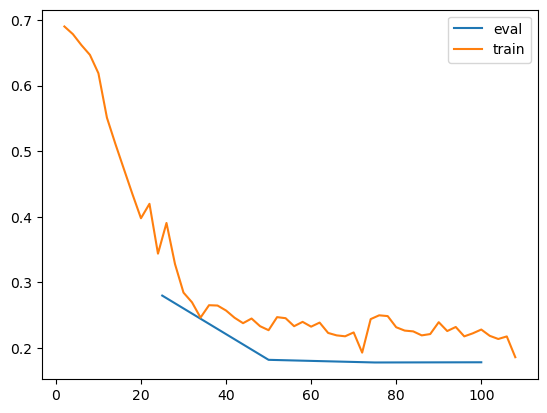

In [239]:
# Plot loss curves from trainer
import matplotlib.pyplot as plt

xs_train, loss_train = [], []
xs_eval, loss_eval = [], []
for x, log in enumerate(trainer.state.log_history):
    if "loss" in log:
        xs_train.append(log["step"])
        loss_train.append(log["loss"])
    if "eval_loss" in log:
        xs_eval.append(log["step"])
        loss_eval.append(log["eval_loss"])

plt.plot(xs_eval, loss_eval, label="eval")
plt.plot(xs_train, loss_train, label="train")
plt.legend()

In [240]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(corpus["train"])
    labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

# Get optimal cut-off for each phone
optimal_thresholds = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, j]
    labels_j = labels[:, j]

    mask = labels_j != -100
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

  0%|          | 0/578 [00:00<?, ?it/s]

/Users/jon/miniforge3/envs/explore310/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


[inf,
 -3.4889586,
 -3.9734268,
 -3.968787,
 -3.9641473,
 -3.9661562,
 -3.5051877,
 -3.502897,
 -3.1076362,
 -3.1074262,
 -3.108233,
 -3.1115975,
 -3.1601715,
 -3.1164033,
 -2.6181695,
 -2.6201882,
 -2.6188586,
 -2.617701,
 -2.6176703,
 -2.6195345,
 -2.6201777,
 -2.618324,
 -2.6199024,
 -2.6220047,
 -2.641912,
 -2.6393645,
 -2.6410055,
 -2.6397583,
 -2.6406913,
 -2.641306,
 -2.6427617,
 -2.6419036,
 -2.6427083,
 -2.6400003,
 -2.6419115,
 -2.6390686,
 -2.641331,
 -2.638675,
 -2.6408086,
 -2.6422489,
 -2.6385264,
 -2.6392205,
 -2.6375756,
 -2.64102,
 -2.6386611,
 -2.637971,
 -2.640559,
 -2.6401594,
 -2.6405225,
 -2.6377006,
 -2.6401496,
 -2.7893584,
 -2.794978,
 -2.7954838,
 -2.7895405,
 -2.7897618,
 -2.7904587,
 -2.7890353,
 -2.7897837,
 -2.7912993,
 -2.7904634,
 -2.7903545,
 -2.7891924]

In [245]:
def predict(batch):
    features = processor(batch["input_values"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values

    with torch.no_grad():
        logits = model(input_values).logits
    preds = (logits > optimal_thresholds).int().numpy()

    # TODO trim based on label padding to match actual input length
    batch["score"] = logits.numpy()
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds
    batch["predicted"] = preds
    return batch

eval_result = corpus["test"].select(range(30)).map(predict, batched=True, batch_size=8)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

torch.Size([8, 248, 63]) torch.Size([63])
torch.Size([8, 371, 63]) torch.Size([63])
torch.Size([8, 275, 63]) torch.Size([63])
torch.Size([6, 209, 63]) torch.Size([63])


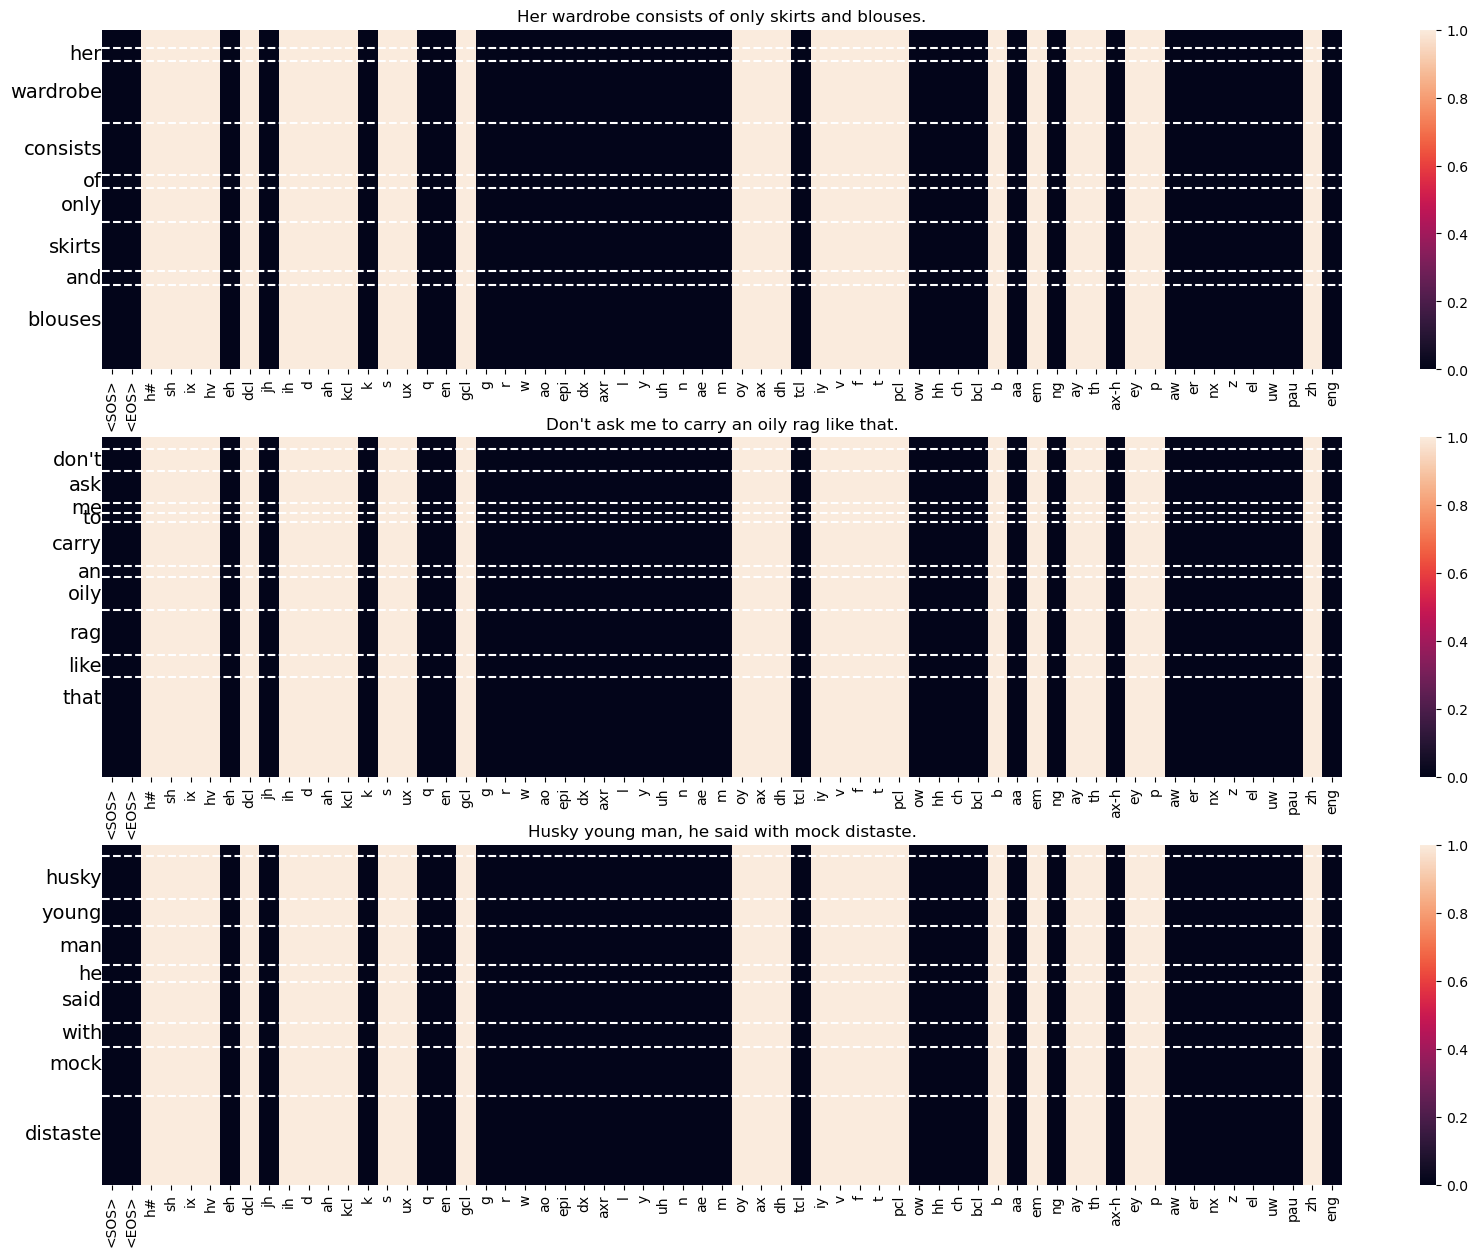

In [252]:
# viz phoneme predictions
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_batch_frames = len(item["predicted"])#.shape[0]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_batch_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    result = pd.DataFrame(item["predicted"], columns=phone_vocab.index2token)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

In [223]:
# y_true = [all_dialects[i] for i in eval_result["labels"]]
# y_pred = [all_dialects[i] for i in eval_result["predicted"]]
y_true = eval_result["labels"]
y_pred = eval_result["predicted"]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred, target_names=all_dialects))

KeyError: "Column labels not in the dataset. Current columns in the dataset: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'score', 'distance_from_decision_threshold', 'predicted']"

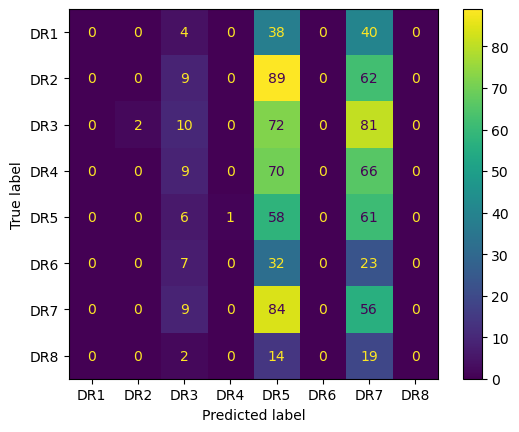

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=all_dialects).plot()

In [ ]:
# Generate input/output samples

# Maximum length of a word, in phones
max_word_length = 10

# Include this many phones to the left and right of a target word token
width_lookback, width_lookforward = 5, 5

samples = torch.zeros((corpus.num_word_instances,
                       max_word_length + width_lookback + width_lookforward,
                       corpus.num_phone_types))

i = 0
# TODO assumes contiguous phone_idx. is this right?
for sentence_key, sentence_row in corpus._df.groupby(["dialect", "speaker", "sentence_idx"]):
    phone_idxs = sentence_row.index.get_level_values("phone_idx")
    for word_idx, phones in sentence_row.groupby("word_idx"):
        word_phone_idxs = phones.index.get_level_values("phone_idx")
        phone_onset, phone_offset = word_phone_idxs[0], word_phone_idxs[-1]

        window_left = max(0, phone_onset - width_lookback)
        window_right = min(phone_offset + width_lookforward, len(phones))

        input_span = sentence_row.loc[(phone_idxs >= window_left) & (phone_idxs < window_right - 1)]

        # TODO convert this into actual sample in torch tensor

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tr